In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read each sheet of the Excel file into separate DataFrames
file_path = "..\\DataCleaning\\resources\\complete_stock_data.csv"
# Read the CSV file into a DataFrame
final_df = pd.read_csv(file_path)
final_df.head()

,ASX Code,Security Group Code,Issuer Full Name,Product Description,Last Price($),Business Date,Year,Company Name,Sub-Industry,Splits,Dividends
0,1AD,EQY,ADALTA LIMITED ...,ORDINARY,0.280,20170630,2017,Adalta Limited Ordinary,Biotechnology & Medical Research,1.0,0.0
1,1AG,EQY,ALTERRA LIMITED ...,ORDINARY,0.024,20170630,2017,Alterra Limited Ordinary,Environmental Services & Equipment,1.0,0.0
2,3DP,EQY,POINTERRA LIMITED ...,ORDINARY,0.025,20170629,2017,Pointerra Limited Ordinary,Software,1.0,0.0
3,3PL,EQY,3P LEARNING LIMITED.. ...,ORDINARY,1.045,20170630,2017,3P Learning Limited. Ordinary,Software,1.0,0.0
4,4DS,EQY,4DS MEMORY LIMITED ...,ORDINARY,0.037,20170630,2017,4DS Memory Limited Ordinary,Computer Hardware,1.0,0.0


In [2]:
final_df.head()

,ASX Code,Security Group Code,Issuer Full Name,Product Description,Last Price($),Business Date,Year,Company Name,Sub-Industry,Splits,Dividends
0,1AD,EQY,ADALTA LIMITED ...,ORDINARY,0.280,20170630,2017,Adalta Limited Ordinary,Biotechnology & Medical Research,1.0,0.0
1,1AG,EQY,ALTERRA LIMITED ...,ORDINARY,0.024,20170630,2017,Alterra Limited Ordinary,Environmental Services & Equipment,1.0,0.0
2,3DP,EQY,POINTERRA LIMITED ...,ORDINARY,0.025,20170629,2017,Pointerra Limited Ordinary,Software,1.0,0.0
3,3PL,EQY,3P LEARNING LIMITED.. ...,ORDINARY,1.045,20170630,2017,3P Learning Limited. Ordinary,Software,1.0,0.0
4,4DS,EQY,4DS MEMORY LIMITED ...,ORDINARY,0.037,20170630,2017,4DS Memory Limited Ordinary,Computer Hardware,1.0,0.0


In [3]:
final_df["ASX Code"].nunique()

1858

In [4]:
final_df["ASX Code"].count()

11745

In [5]:
# Try to apply Splits on the prices of previous years so that we can apply it on the price

# Step 1: Identify Split Events
split_events = final_df[final_df['Splits'] != 1]  # Only select rows where Splits is not equal to 1

# Step 2: Adjust Historical Prices
for _, split_event in split_events.iterrows():
    split_date = split_event['Year']
    split_ratio = split_event['Splits']
    asx_code = split_event['ASX Code']
    
    # Adjust historical prices for the ASX code before the split date
    final_df.loc[(final_df['ASX Code'] == asx_code) & (final_df['Year'] < split_date), 'Last Price($)'] /= split_ratio


In [6]:
# convert the dividends from percent to dollar
final_df['Dividends'] = final_df['Dividends'] * final_df['Last Price($)'] /100

# Group data by 'ASX Code' and 'Year', and sort each group by 'Year' before finding the first and last prices
first_last_prices = final_df.groupby(['ASX Code', 'Year']).apply(lambda x: x.sort_values('Year')).reset_index(drop=True).groupby('ASX Code').agg({'Year': ['first', 'last'], 'Last Price($)': ['first', 'last'], 'Dividends': 'sum', 'Sub-Industry': 'last'}).reset_index()

# Rename the columns for clarity
first_last_prices.columns = ['ASX Code', 'First Year', 'Last Year', 'First Price', 'Last Price', 'Total Dividends', 'Sub-Industry']

# Display data for preview
first_last_prices

,ASX Code,First Year,Last Year,First Price,Last Price,Total Dividends,Sub-Industry
0,14D,2019,2023,0.295,0.048,0.0,Electrical Components & Equipment
1,1AD,2017,2023,0.280,0.024,0.0,Biotechnology & Medical Research
2,1AE,2022,2023,0.205,0.063,0.0,Uranium
3,1AG,2016,2023,0.052,0.010,0.0,Environmental Services & Equipment
4,1MC,2022,2023,0.017,0.008,0.0,Specialty Mining & Metals
...,...,...,...,...,...,...,...
1853,ZLD,2017,2023,0.074,1.510,0.0,Biotechnology & Medical Research
1854,ZMI,2017,2023,0.005,0.020,0.0,Integrated Mining
1855,ZMM,2021,2023,0.014,0.031,0.0,Electrical Components & Equipment
1856,ZNC,2014,2023,0.085,0.090,0.0,Integrated Mining


In [7]:
# Calculate total return (price appreciation + dividends)
first_last_prices['Total Return'] = first_last_prices['Last Price'] - first_last_prices['First Price'] + first_last_prices['Total Dividends']
# Normalize total return
first_last_prices['Normalized Total Return'] = first_last_prices['Total Return'] / first_last_prices['First Price']

# Sort ASX codes based on normalized total return
sorted_data = first_last_prices.sort_values(by='Normalized Total Return', ascending=False)

# Create report
top_gainers_report = sorted_data[['ASX Code', 'Total Return', 'Normalized Total Return', 'First Price', 'Last Price', 'Sub-Industry','Total Dividends']]

# Display or export the report as needed
top_gainers_report.head(10) # Display top 10 gainers


,ASX Code,Total Return,Normalized Total Return,First Price,Last Price,Sub-Industry,Total Dividends
522,DEG,1.344000,1344.000000,0.001,1.345,Gold,0.000000
1117,MOT,1.998000,999.000000,0.002,2.000,Closed End Funds,0.000000
811,HLS,3.174000,529.000000,0.006,3.180,Healthcare Facilities & Services,0.000000
746,GLN,0.868000,434.000000,0.002,0.870,Specialty Mining & Metals,0.000000
176,ARX,0.922000,307.333333,0.003,0.925,"Medical Equipment, Supplies & Dist'n",0.000000
478,CTT,3.108989,282.635364,0.011,3.110,Apparel & Accessories Retailers,0.009989
1514,SEQ,0.533000,266.500000,0.002,0.535,Investment Management & Fund Operators,0.000000
1785,WBT,5.051000,265.842105,0.019,5.070,Semiconductors,0.000000
1248,OBL,2.610000,261.000000,0.010,2.620,Corporate Financial Services,0.000000
214,AVD,0.738824,246.274667,0.003,0.740,Construction & Engineering,0.001824


In [8]:
# Display or export the report as needed
top_gainers_report.tail(10)  # Display least 10 gainers


,ASX Code,Total Return,Normalized Total Return,First Price,Last Price,Sub-Industry,Total Dividends
1843,YPB,-0.247000,-0.988000,0.250,0.0030,IT Services & Consulting,0.000000
1715,TTT,-2.669299,-0.988629,2.700,0.0180,Industrial Machinery & Equipment,0.012701
653,EXL,-1.432000,-0.991003,1.445,0.0130,Other Specialty Retailers,0.000000
222,AVW,-0.248000,-0.992000,0.250,0.0020,Gold,0.000000
142,AO1,-0.159000,-0.993750,0.160,0.0010,Software,0.000000
53,ADR,-0.497500,-0.995000,0.500,0.0025,Advanced Medical Equipment & Technology,0.000000
619,ENV,-1.355000,-0.996324,1.360,0.0050,Precious Metals & Minerals,0.000000
568,DXN,-0.274000,-0.996364,0.275,0.0010,IT Services & Consulting,0.000000
474,CTN,-1.022000,-0.997073,1.025,0.0030,Integrated Mining,0.000000
196,ATU,-1.705000,-0.997076,1.710,0.0050,Steel,0.000000


#### Visualizing top 5 gainers 

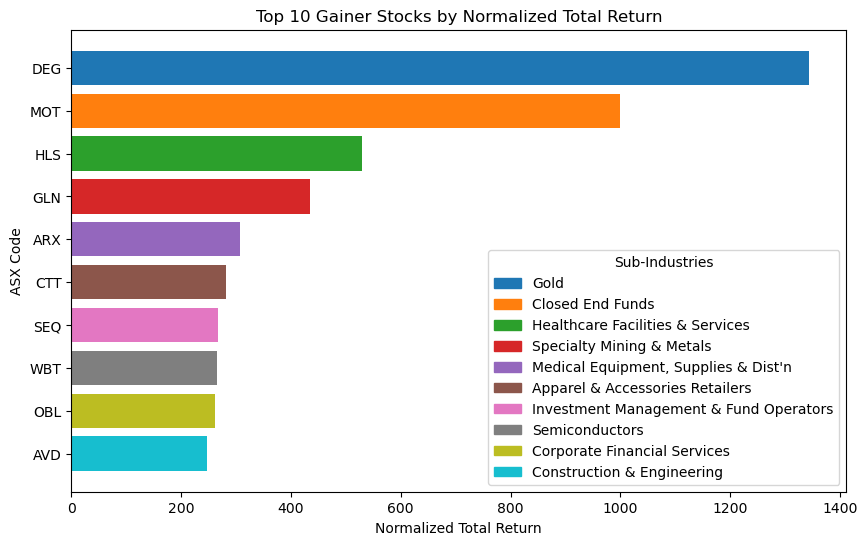

In [9]:
# Data
top_gainers = top_gainers_report[['ASX Code', 'Normalized Total Return', 'Sub-Industry']].head(5)
top_ten_gainers = top_gainers_report[['ASX Code', 'Normalized Total Return', 'Sub-Industry']].head(10)
asx_codes = top_ten_gainers['ASX Code']
normalized_total_returns = top_ten_gainers['Normalized Total Return']
sub_industries = top_ten_gainers['Sub-Industry']

# Assigning unique colors to each sub-industry
unique_sub_industries = sub_industries.unique()
colors = plt.cm.tab10.colors[:len(unique_sub_industries)]  # Using tab10 colormap for colors

# Create a dictionary to map each sub-industry to a color and track if it's already in the legend
color_map = {}
handles = []
for i, (sub_industry, color) in enumerate(zip(unique_sub_industries, colors)):
    if sub_industry not in color_map:
        color_map[sub_industry] = color
        handles.append((sub_industry, color))

# Create a bar plot with consistent colors for each sub-industry
plt.figure(figsize=(10, 6))
legend_handles = []
for asx_code, normalized_total_return, sub_industry in zip(asx_codes, normalized_total_returns, sub_industries):
    if sub_industry in color_map:
        plt.barh(asx_code, normalized_total_return, color=color_map[sub_industry])
        # Add the sub-industry to the legend if it's the first occurrence
        if sub_industry not in legend_handles:
            legend_handles.append(sub_industry)

plt.xlabel('Normalized Total Return')
plt.ylabel('ASX Code')
plt.title('Top 10 Gainer Stocks by Normalized Total Return')

# Create custom legend labels
legend_labels = [plt.Rectangle((0,0),1,1, color=color_map[sub_industry]) for sub_industry in legend_handles]
plt.legend(handles=legend_labels, labels=legend_handles, loc='lower right', title='Sub-Industries')
plt.gca().invert_yaxis()  # Invert y-axis to display highest return at the top
# Save the chart
plt.savefig('Output/top_ten_gainer_stocks_by_normalized_total_return.png', bbox_inches='tight')
plt.show()


### Visualizing bottom 5 gainers

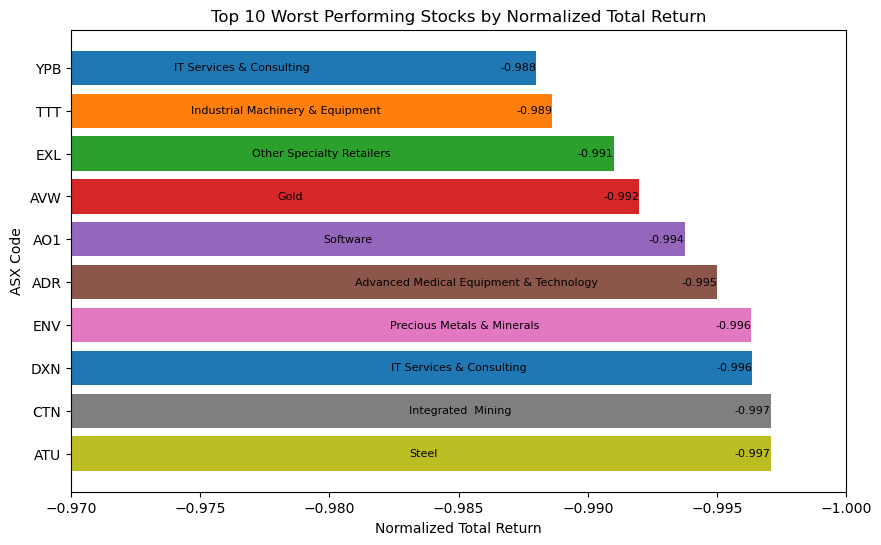

In [10]:
# Creating chart for the lowest gainers during 10 years
import matplotlib.pyplot as plt

# Data
bottom_gainers = top_gainers_report[['ASX Code', 'Normalized Total Return', 'Sub-Industry']].tail(5)
bottom_ten_gainers = top_gainers_report[['ASX Code', 'Normalized Total Return', 'Sub-Industry']].tail(10)
asx_codes = bottom_ten_gainers['ASX Code']
normalized_total_returns = bottom_ten_gainers['Normalized Total Return']
sub_industries = bottom_ten_gainers['Sub-Industry']

# Assigning colors to each unique sub-industry
unique_sub_industries = sub_industries.unique()
colors = plt.cm.tab10(range(len(unique_sub_industries)))

# Create a bar plot with consistent colors for each sub-industry
plt.figure(figsize=(10, 6))
for i, (asx_code, normalized_total_return, sub_industry) in enumerate(zip(asx_codes, normalized_total_returns, sub_industries)):
    color = colors[list(unique_sub_industries).index(sub_industry)]
    plt.barh(asx_code, normalized_total_return, color=color)
    # Add sub-industry label on each bar
    plt.text(normalized_total_return + 0.014, asx_code, sub_industry, ha='left', va='center', fontsize=8, color='black')

    # Add normalized total return value on the border of each bar
    plt.text(normalized_total_return, asx_code, f'{normalized_total_return:.3f}', ha='right', va='center', fontsize=8, color='black')

plt.xlabel('Normalized Total Return')
plt.ylabel('ASX Code')
plt.title('Top 10 Worst Performing Stocks by Normalized Total Return')

# Set x-axis limits
plt.xlim(-0.97, -1)

plt.gca().invert_yaxis()  # Invert y-axis to display the highest return at the top

# Save the chart
plt.savefig('Output/bottom_ten_gainer_stocks_by_normalized_total_return.png', bbox_inches='tight')

plt.show()

### Movement of each top gainer stock over 10 years

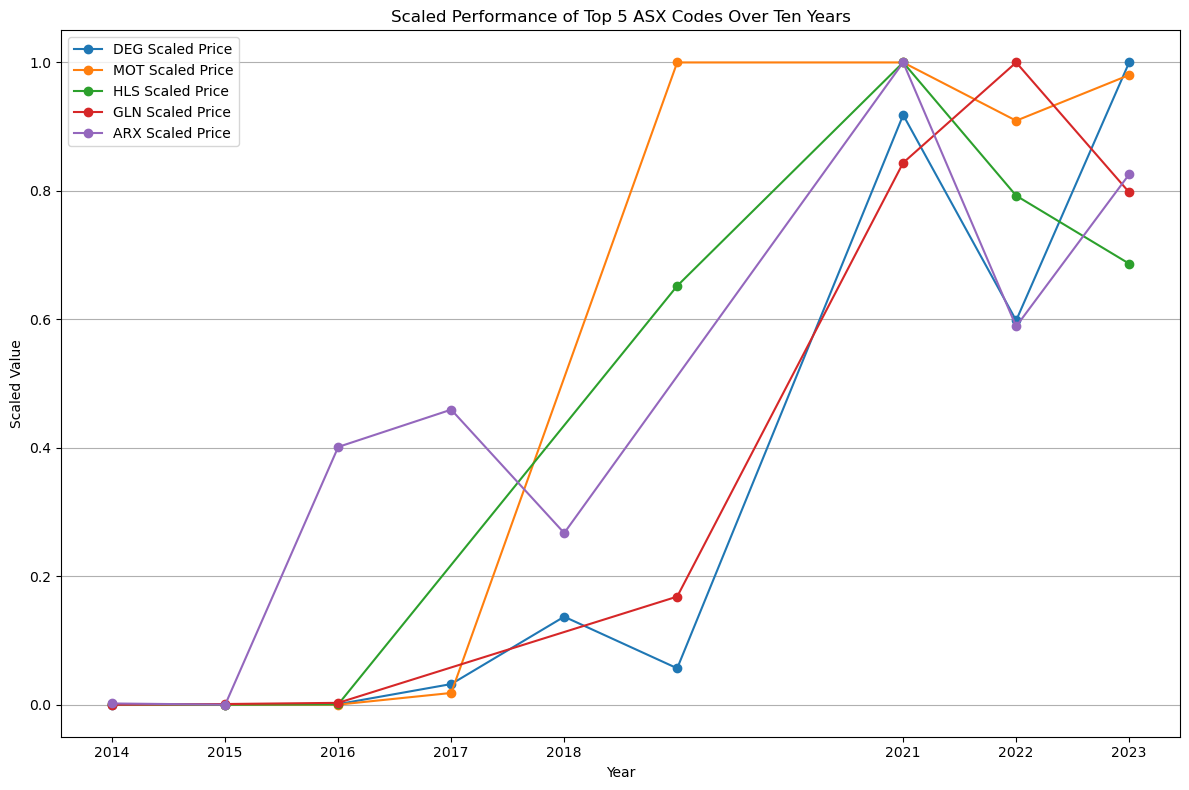

In [11]:
#top_gainers
asx_codes = top_gainers['ASX Code']


# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over each top gainer
for i in range(5):
    next_top_asx_code = asx_codes.iloc[i]

    # Filter data for top ASX Code
    mtb_data = final_df[final_df['ASX Code'] == next_top_asx_code].copy()

    # Aggregate data by year
    mtb_data_agg = mtb_data.groupby('Year')[['Last Price($)', 'Dividends', 'Splits']].mean()

    # Remove negative values from Last Price
    mtb_data_agg = mtb_data_agg[mtb_data_agg['Last Price($)'] >= 0]

    # Scale the prices
    min_price = mtb_data_agg['Last Price($)'].min()
    max_price = mtb_data_agg['Last Price($)'].max()
    scaled_prices = (mtb_data_agg['Last Price($)'] - min_price) / (max_price - min_price)

    # Plot scaled Price
    ax.plot(mtb_data_agg.index, scaled_prices, label=f'{next_top_asx_code} Scaled Price', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Scaled Value')
plt.title('Scaled Performance of Top 5 ASX Codes Over Ten Years')

# Set x-ticks to ensure all years are displayed
ax.set_xticks(mtb_data_agg.index)

# Add legend
plt.legend()

# Show the plot
plt.grid(axis='y')
plt.tight_layout()

# Save the chart
plt.savefig('Output/scaled_performance_of_top_5_ASX_codes_over_ten_years.png', bbox_inches='tight')

plt.show()


### Movement of each bottom gainer stock over 10 years

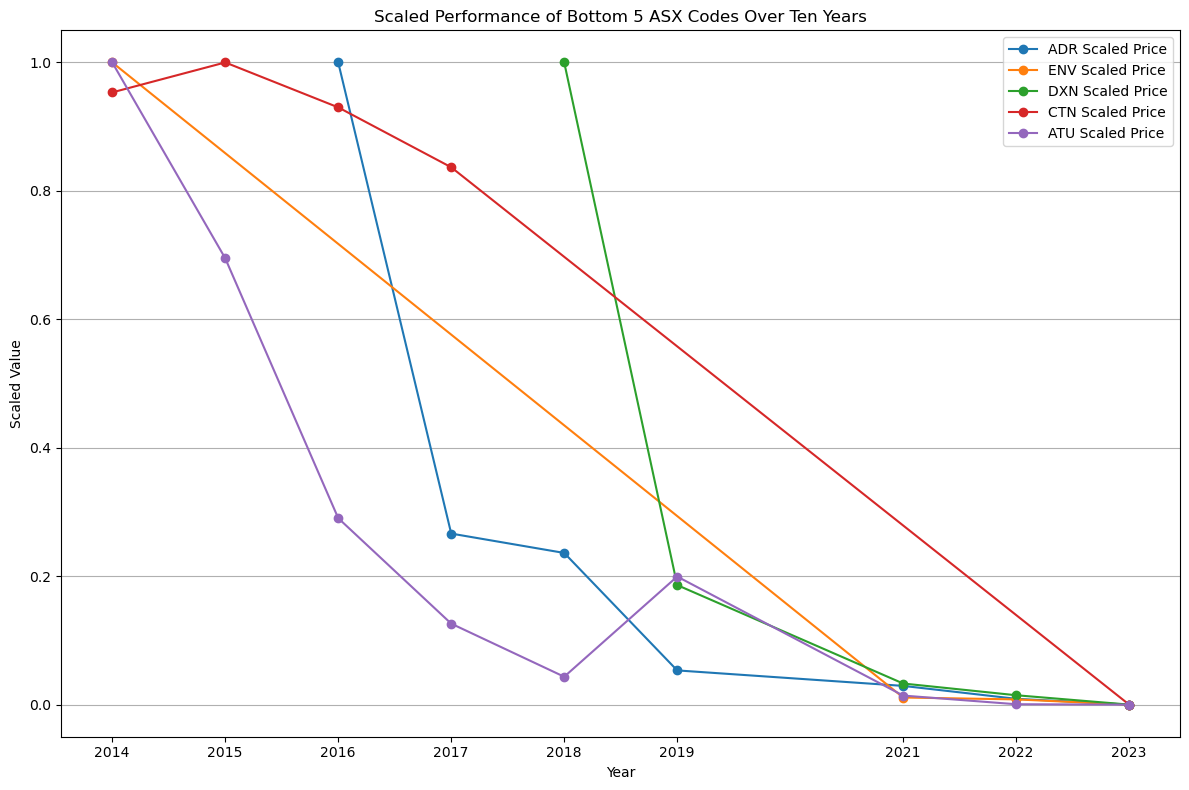

In [12]:
#top_gainers
bottom_asx_codes = bottom_gainers['ASX Code']


# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over each top gainer
for i in range(5):
    next_bottom_asx_code = bottom_asx_codes.iloc[i]

    # Filter data for top ASX Code
    mtb_data = final_df[final_df['ASX Code'] == next_bottom_asx_code].copy()

    # Aggregate data by year
    mtb_data_agg = mtb_data.groupby('Year')[['Last Price($)', 'Dividends', 'Splits']].mean()

    # Remove negative values from Last Price
    mtb_data_agg = mtb_data_agg[mtb_data_agg['Last Price($)'] >= 0]

    # Scale the prices
    min_price = mtb_data_agg['Last Price($)'].min()
    max_price = mtb_data_agg['Last Price($)'].max()
    scaled_prices = (mtb_data_agg['Last Price($)'] - min_price) / (max_price - min_price)

    # Plot scaled Price
    ax.plot(mtb_data_agg.index, scaled_prices, label=f'{next_bottom_asx_code} Scaled Price', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Scaled Value')
plt.title('Scaled Performance of Bottom 5 ASX Codes Over Ten Years')

# Set x-ticks to ensure all years are displayed
ax.set_xticks(mtb_data_agg.index)

# Add legend
plt.legend()

# Show the plot
plt.grid(axis='y')
plt.tight_layout()

# Save the chart
plt.savefig('Output/scaled_performance_of_bottom_5_ASX_codes_over_ten_years.png', bbox_inches='tight')

plt.show()


### Top ten performing sub industries.

In [13]:
# finding top sub industries.

top_sub_industries = top_gainers_report.groupby('Sub-Industry')['Normalized Total Return'].mean()
top_sub_industries = top_sub_industries.sort_values(ascending=False)
top_sub_industries.columns = ['Sub-Industry', 'Normalized Total Return']
top_sub_industries.head(10)

Sub-Industry
Closed End Funds                        110.815837
Semiconductors                           53.977563
Corporate Financial Services             38.325007
Apparel & Accessories Retailers          32.474978
Communications & Networking              27.369007
Healthcare Facilities & Services         24.276875
Aluminum                                 22.895681
Personal Products                        20.310454
Medical Equipment, Supplies & Dist'n     19.435367
Heavy Electrical Equipment               13.230769
Name: Normalized Total Return, dtype: float64

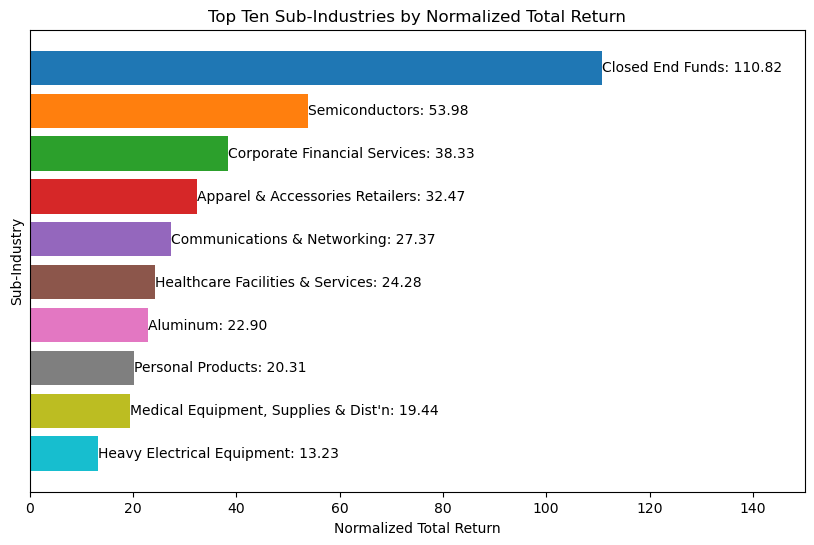

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Grouping Data
top_sub_df = top_gainers_report.groupby('Sub-Industry')['Normalized Total Return'].mean().nlargest(10)

# Get a list of unique sub-industries
unique_sub_industries = top_sub_df.index.tolist()

# Choose a color map
color_map = plt.get_cmap('tab10')

# Plotting
plt.figure(figsize=(10, 6))
for index, (sub_industry, value) in enumerate(top_sub_df.items()):
    color = color_map(index % 10)  # Use modulo to ensure colors repeat if there are more than 10 sub-industries
    plt.barh(sub_industry, value, color=color)
    plt.text(value, index, f'{sub_industry}: {value:.2f}', va='center', ha='left', fontsize=10, color='black')

# Axis Configuration
plt.xlabel('Normalized Total Return')
plt.ylabel('Sub-Industry')
plt.title('Top Ten Sub-Industries by Normalized Total Return')
plt.xlim(0, 150)
plt.gca().invert_yaxis()
plt.yticks([], [])

# Save the chart
plt.savefig('Output/top_ten_sub-industries_by_normalized_total_return.png', bbox_inches='tight')

plt.show()